In [3]:
# test GPU function (e.g., for Google Colab)
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May 12 15:26:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, MultiHeadAttention, LSTM, Conv1D, Dense, GlobalAveragePooling1D, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from transformers import AutoTokenizer
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import ReduceLROnPlateau
import torch
import pandas as pd
import numpy as np

In [5]:
#mounting on g drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Challenge 1: 20 Newsgroups

You are provided with training data from the 20 Newsgroups dataset, which consists of forum posts covering a wide range of topics. These posts originate from 20 distinct forums. Your task is to develop a classifier that takes a given post as input and predicts the forum from which it originated.

To simplify the task — given that some forums are highly similar — we have grouped the 20 forums into 6 broader categories. Your classifier will be evaluated based on its accuracy in predicting these 6 categories. However, you are encouraged to make use of the full 20-category dataset for training purposes if you wish.

Finally, we will ask you to show the process you used to develop your classifier. Do not train your model on the evaluation dataset, as this is cheating.

### The Dataset

In [6]:
#here we are loading the dataset that was given, "twentyngd" is the variable thats holding our dataset
#libes
twentyngdf = pd.read_json('/content/drive/My Drive/Dataset/train.jsonl', lines = True)
twentyngdf
test_df = pd.read_json('/content/drive/My Drive/Dataset/test.jsonl', lines=True)

### Grouping the Forums

As said, you do not need to map the post to its exact forum but only which super group the post belongs to. Below you find the mapping in the form of a callable object.

In [7]:
class Grouping_NewsForums():
    def __init__(self):
        self.grouping = {
            0 : 0,
            1 : 1,
            2 : 1,
            3 : 1,
            4 : 1,
            5 : 1,
            6 : 2,
            7 : 3,
            8 : 3,
            9 : 3,
            10 : 3,
            11 : 4,
            12 : 4,
            13 : 4,
            14 : 4,
            15 : 0,
            16 : 5,
            17 : 5,
            18 : 5,
            19 : 5,
        }
    def __call__(self, x):
        return self.grouping[x]

# Load the dataframe
twentyngdf = pd.read_json('/content/drive/My Drive/Dataset/train.jsonl', lines=True)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    twentyngdf['text'], twentyngdf['label'], test_size=0.2, random_state=42
)

# Now you can use y_train and y_val
grouping = Grouping_NewsForums()
grouped_y_train = [grouping(label) for label in y_train]
grouped_y_val = [grouping(label) for label in y_val]
grouped_y_test = [grouping(label) for label in test_df['label']]


### Number to Forum Name

We provide this utility function to help you easily recall the meaning of each category label—especially if, like me, you find it hard to remember the category numbers.

In [8]:
label_names = ['alt.atheism',
               'comp.graphics',
               'comp.os.ms-windows.misc',
               'comp.sys.ibm.pc.hardware',
               'comp.sys.mac.hardware',
               'comp.windows.x',
               'misc.forsale',
               'rec.autos',
               'rec.motorcycles',
               'rec.sport.baseball',
               'rec.sport.hockey',
               'sci.crypt',
               'sci.electronics',
               'sci.med',
               'sci.space',
               'soc.religion.christian',
               'talk.politics.guns',
               'talk.politics.mideast',
               'talk.politics.misc',
               'talk.religion.misc']

label_convertion_dict = {}
for i in range(len(label_names)):
    label_convertion_dict[i] = label_names[i]
    label_convertion_dict[label_names[i]] = i

def label_convertion(label):
    return label_convertion_dict[label]

### Let's go, good luck!!

In [9]:
# Tokenization
# Load the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Load the dataframe
twentyngdf = pd.read_json('/content/drive/My Drive/Dataset/train.jsonl', lines=True)

# Tokenize the text data
def tokenize_function(text):
    return tokenizer(text, padding="max_length", truncation=True, max_length=100, return_tensors="tf")

X_train, X_val, y_train, y_val = train_test_split(
    twentyngdf['text'], twentyngdf['label'], test_size=0.2, random_state=42
)

X_test_vec = [tokenize_function(text) for text in test_df['text']]
X_test_input_ids = tf.stack([x['input_ids'][0] for x in X_test_vec], axis=0)

# Apply tokenization to the dataset
X_train_vec = [tokenize_function(text) for text in X_train]
X_val_vec = [tokenize_function(text) for text in X_val]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [10]:
# Create Embedding Layer
# Define vocabulary size and embedding dimension
vocab_size = tokenizer.vocab_size  # BERT's vocabulary size
embedding_dim = 100  # Max words considered at input

# Create the embedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)

# Get token IDs from the first tokenized sample in X_train_vec
# Extract token IDs from the 'input_ids' field
token_ids = X_train_vec[0]['input_ids'].numpy().flatten().tolist()

# Convert to TensorFlow tensor
token_ids_tensor = tf.constant(token_ids, dtype=tf.int32)

# Get embeddings for the token IDs
embedded = embedding_layer(token_ids_tensor)

print(embedded.shape)

(100, 100)


In [11]:
!pip install --upgrade scikit-learn


In [12]:
#Attention
def attention_model():
    input_layer = Input(shape=(100,), dtype=tf.int32)  # Input shape matches tokenized output
    embeddings = embedding_layer(input_layer)
    attention_output = MultiHeadAttention(num_heads=8, key_dim=embedding_dim)(embeddings, embeddings)
    pooled_output = GlobalAveragePooling1D()(attention_output)
    output_layer = Dense(6, activation='softmax')(pooled_output)  # 6 output classes
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [13]:
#Compile and Train
model = attention_model()
model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#Adjustable learning rate

In [20]:
#Train the Model
#Convert X_train_vec and X_val_vec to NumPy arrays if needed
X_train_input_ids = tf.stack([x['input_ids'][0] for x in X_train_vec], axis=0)
X_val_input_ids = tf.stack([x['input_ids'][0] for x in X_val_vec], axis=0)

#ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

# Assign the output of model.fit to history
history = model.fit(
    X_train_input_ids, # Use the extracted token IDs
    np.array(grouped_y_train),
    epochs=10,  # Adjust as needed
    batch_size=64,  # Adjust this value
    validation_data=(X_val_input_ids, np.array(grouped_y_val)), # Use the extracted token IDs for validation
    callbacks=[reduce_lr]  # Pass the callback here

)

Epoch 1/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9762 - loss: 0.0614 - val_accuracy: 0.7777 - val_loss: 0.9736 - learning_rate: 1.0000e-05
Epoch 2/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9784 - loss: 0.0562 - val_accuracy: 0.7777 - val_loss: 0.9773 - learning_rate: 1.0000e-05
Epoch 3/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9773 - loss: 0.0603 - val_accuracy: 0.7777 - val_loss: 0.9819 - learning_rate: 1.0000e-05
Epoch 4/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9763 - loss: 0.0634 - val_accuracy: 0.7786 - val_loss: 0.9867 - learning_rate: 1.0000e-05
Epoch 5/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9772 - loss: 0.0588 - val_accuracy: 0.7777 - val_loss: 0.9914 - learning_rate: 1.0000e-05
Epoch 6/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9741 - loss: 0.0624 - val_accuracy: 0.7773 - val_loss: 0.9957 - learning_rate: 1.0000e-05
Epoch 7/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc

In [21]:
#Evaluate the Model
# Extract token IDs from X_val_vec
X_val_input_ids = tf.stack([x['input_ids'][0] for x in X_val_vec], axis=0)

# Now evaluate the model using the extracted token IDs
loss, accuracy = model.evaluate(X_val_input_ids, np.array(grouped_y_val))
#print(f"Validation Loss: {loss:.4f}")
#print(f"Validation Accuracy: {accuracy:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7566 - loss: 1.2333


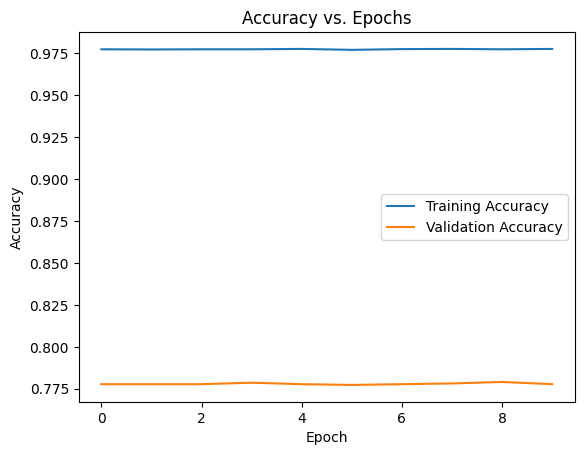

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')
plt.show()

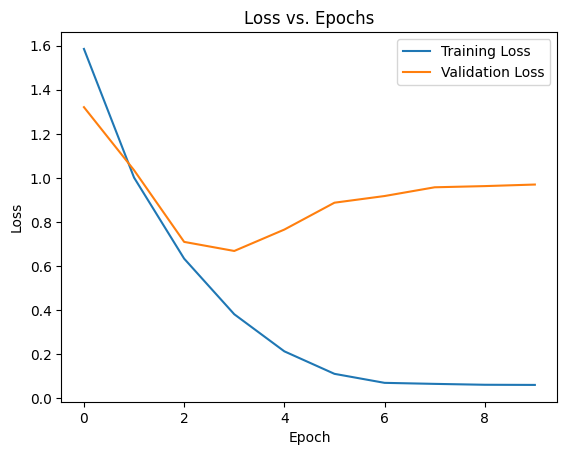

In [17]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epochs')
plt.show()

In [18]:
#Make Predictions
predictions = model.predict(X_test_input_ids)

#Convert Predictions to Class Labels
predicted_labels = np.argmax(predictions, axis=1)

#Evaluate Performance
accuracy = accuracy_score(grouped_y_test, predicted_labels)
print(f"Test Accuracy: {accuracy:.4f}")

236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Test Accuracy: 0.7484


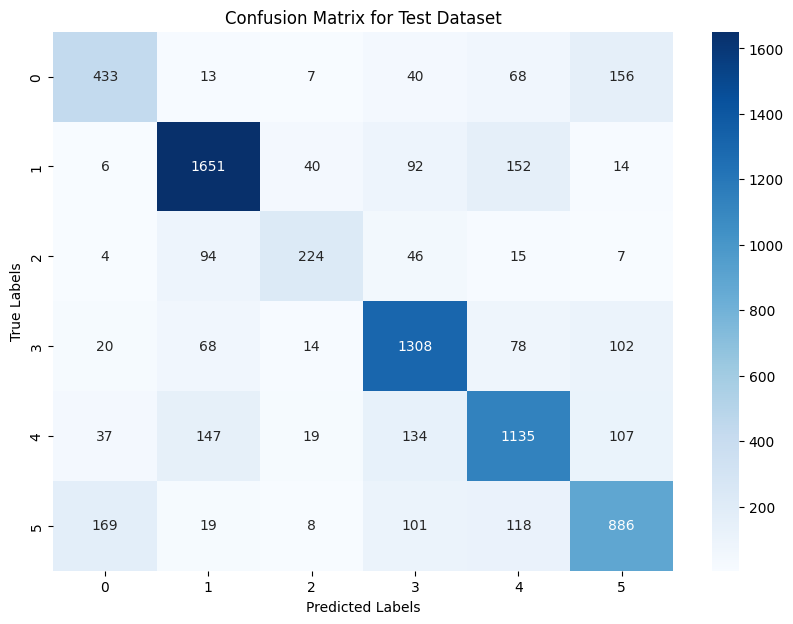

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(grouped_y_test, predicted_labels)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(grouped_y_test),
            yticklabels=np.unique(grouped_y_test))

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Test Dataset')
plt.show()